In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

In [2]:
#Load Data
df = pd.read_csv("../data/creditcard.csv")

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

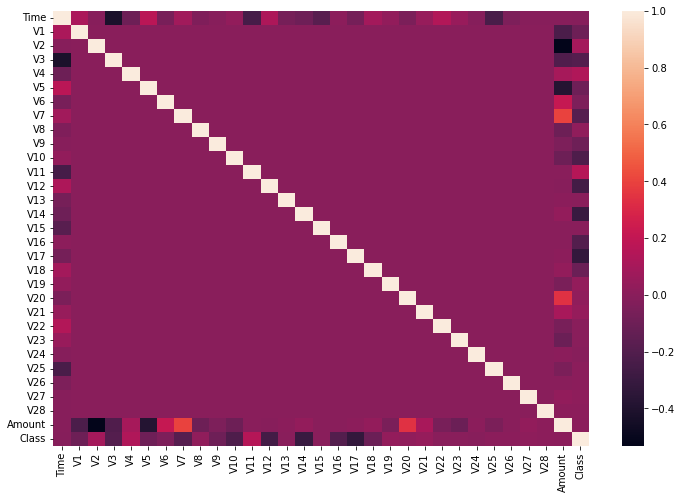

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

In [5]:
anomalies = df[df["Class"]==1]
no_anomalies = df[df["Class"]==0]

In [6]:
anomalies.shape

(492, 31)

In [7]:
no_anomalies.shape

(284315, 31)

In [8]:
print("number of samples :", df.shape[0])
print("number of anomalies : ", anomalies.shape[0])

number of samples : 284807
number of anomalies :  492


In [9]:
con_rate = anomalies.shape[0]/df.shape[0]
con_rate

0.001727485630620034

In [10]:
X = df.drop(columns = ['Class']).to_numpy()

In [11]:
y = df['Class'].to_numpy().flatten()

In [12]:
df_X = df.drop(columns = ['Class'])

In [13]:
def get_hour_data(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    
    X = _.drop(columns = ['Class']).to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [14]:
def get_hour_rate(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

In [15]:
rate = []
for i in range(48):
    rate.append(get_hour_rate(df, i))

In [16]:
rate

[0.0005049229992426155,
 0.0009025270758122744,
 0.013341804320203304,
 0.007138934651290499,
 0.005545286506469501,
 0.006543723973825104,
 0.0016384489350081922,
 0.006831006831006831,
 0.0009654373431164317,
 0.001904036557501904,
 0.00024131274131274132,
 0.005050505050505051,
 0.001164746991070273,
 0.0011867088607594937,
 0.001619735858460005,
 0.0017870819504723003,
 0.0017985611510791368,
 0.0015232292460015233,
 0.0017429700209156402,
 0.00087576629550857,
 0.0008911663139133341,
 0.0014154281670205238,
 0.00033437360677663843,
 0.002795592830126624,
 0.0010720986330742428,
 0.00399400898652022,
 0.020559680182752713,
 0.0023952095808383233,
 0.015111111111111112,
 0.0,
 0.002644336712208021,
 0.0,
 0.0007849293563579278,
 0.0001256281407035176,
 0.0007221954742416948,
 0.0011994722322178242,
 0.0010407180954858852,
 0.0010285420416559527,
 0.0011710973181871414,
 0.0013914656771799629,
 0.000923041421483789,
 0.002052644288819126,
 0.0021354846363744215,
 0.001567602873938602

In [17]:
from sklearn.neighbors import LocalOutlierFactor

In [18]:
y_true =[]
y_pred = np.array([])
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=5, 
                             algorithm='auto', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=rate[i]*10)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)

In [19]:
from sklearn.metrics import classification_report, accuracy_score
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
errors = (y_pred != y_true).sum() # Total number of errors is calculated.
errors

2815

In [20]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    141935
         1.0       0.49      0.05      0.09      2810

    accuracy                           0.98    144745
   macro avg       0.74      0.52      0.54    144745
weighted avg       0.97      0.98      0.97    144745



In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[141792,   2672],
       [   143,    138]])

In [22]:
sum(y_true)

281.0

In [23]:
y_true =[]
y_pred = np.array([])
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=5, 
                             algorithm='auto', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=max(rate[i+24],0.0001)*10)
    X, y = get_hour_data(df, i+24)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)

In [24]:
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_pred != y_true).sum() # Total number of errors is calculated.
print(errors1)

2154


In [25]:
confusion_matrix(y_true, y_pred)

array([[137753,   2029],
       [   125,     86]])

In [26]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    137878
         1.0       0.41      0.04      0.07      2115

    accuracy                           0.98    139993
   macro avg       0.70      0.52      0.53    139993
weighted avg       0.98      0.98      0.98    139993



## Gaussian Distribution

#### We will be using a gaussin mixture model to find the anomalies

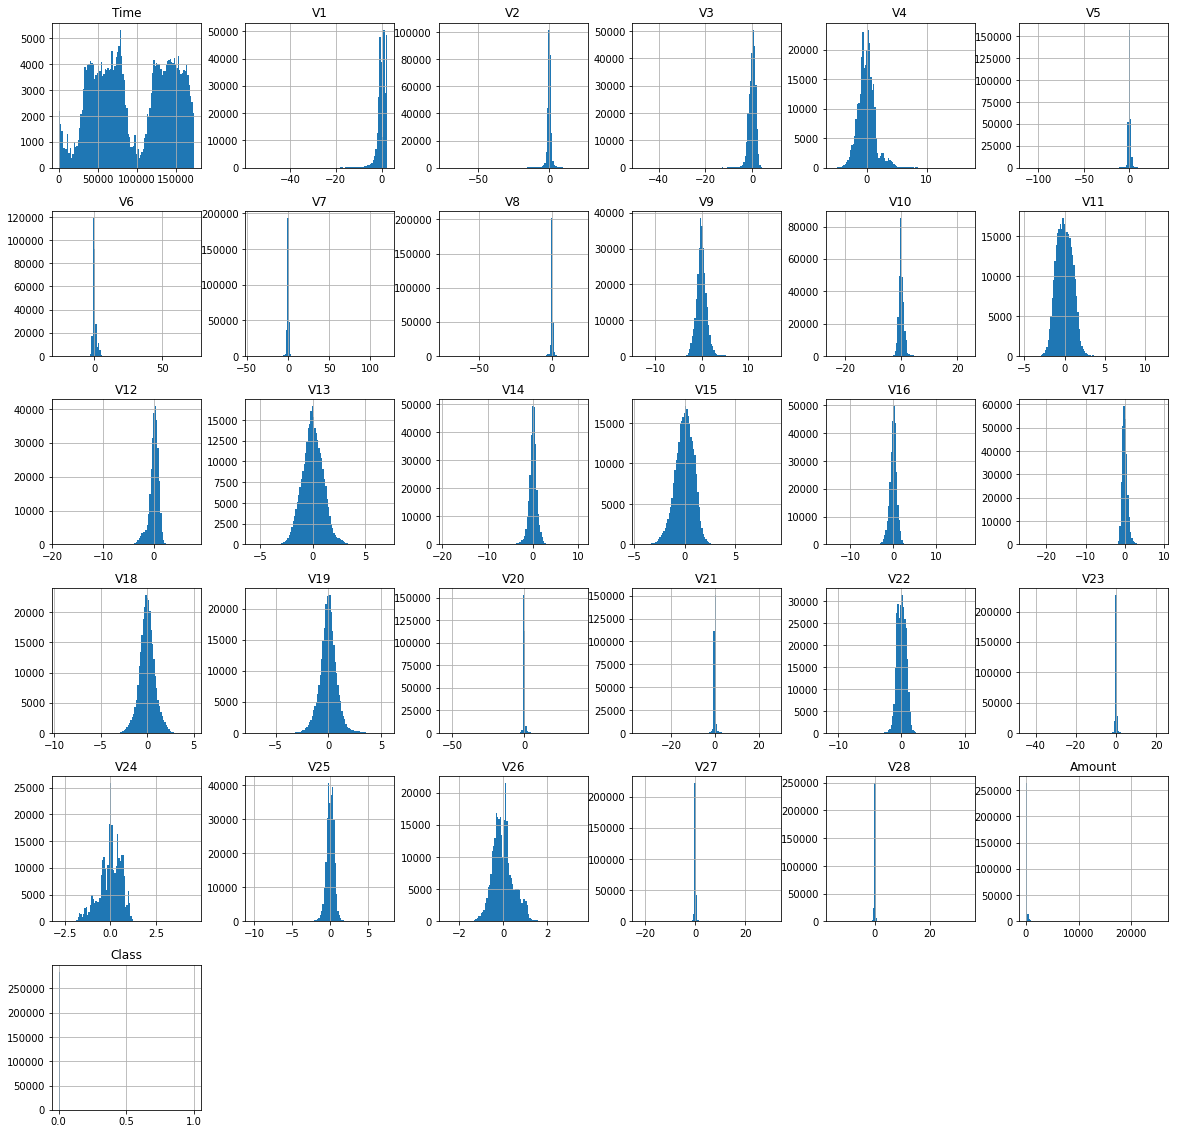

In [27]:
hist = df.hist(bins=100, figsize = (20,20))

From the graphs above we will chose the parameter that look the most like a gaussian distribution

In [28]:
features = ["V9","V11","V13","V15","V18","V19","V14","Class"]
df_features = df[features]

We find the meand and covariance matrix of each feature our dataset and apply them to create a multivariate gaussian distribution

In [29]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
   
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

For our algorithm to work we will need to find the distribution of our dataset and compare the outlier to a p-value or epsilon

Because our data is a little bit unusal having only 492 anomaly we can improve our score by spltting the dataset manually note that this has nothing to do with the detection it's just for splitting purposes 

In [30]:
train_df = df[features]

In [31]:
train_strip_v1 = train_df[train_df["Class"] == 1]
train_strip_v0 = train_df[train_df["Class"] == 0]

In [32]:
Normal_len = len (train_strip_v0)
Anomolous_len = len (train_strip_v1)

start_mid = Anomolous_len // 2
start_midway = start_mid + 1

train_cv_v1  = train_strip_v1 [: start_mid]
train_test_v1 = train_strip_v1 [start_midway:Anomolous_len]

start_mid = (Normal_len * 60) // 100
start_midway = start_mid + 1

cv_mid = (Normal_len * 80) // 100
cv_midway = cv_mid + 1

# Assuming the fact that we have 1% of anomalie there is a small chance that our train will contain some
train_fraud = train_strip_v0 [:start_mid] 
train_cv    = train_strip_v0 [start_midway:cv_mid]
train_test  = train_strip_v0 [cv_midway:Normal_len]

train_cv = pd.concat([train_cv,train_cv_v1],axis=0)
train_test = pd.concat([train_test,train_test_v1],axis=0)

train_cv_y = train_cv["Class"]
train_test_y = train_test["Class"]

train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
train_test.drop(labels = ["Class"], axis = 1, inplace = True)

['V9' 'V11' 'V13' 'V15' 'V18' 'V19' 'V14' 'Class']
['V9' 'V11' 'V13' 'V15' 'V18' 'V19' 'V14' 'Class']
['V9' 'V11' 'V13' 'V15' 'V18' 'V19' 'V14' 'Class']


/tmp/ipykernel_57171/2383900632.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)


Now that we have crooss_validation train and test dataset let's find the anomalies using the gaussian distribution

In [33]:
mu, sigma = estimateGaussian(train_fraud)
p = multivariateGaussian(train_fraud,mu,sigma)
p_cv = multivariateGaussian(train_cv,mu,sigma)
p_test = multivariateGaussian(train_test,mu,sigma)

In [34]:
sigma

array([[ 1.29719298e+00,  4.05340209e-02,  7.69218689e-02,
        -1.46945118e-01, -1.12721828e-02,  7.70082279e-03,
         5.00171401e-02],
       [ 4.05340209e-02,  1.04649783e+00,  2.24316296e-02,
        -3.13130238e-02,  1.87366124e-02, -5.01678441e-02,
         1.11456507e-01],
       [ 7.69218689e-02,  2.24316296e-02,  1.09850615e+00,
        -6.35795710e-02,  3.65368414e-02, -1.06738870e-03,
         9.57856141e-02],
       [-1.46945118e-01, -3.13130238e-02, -6.35795710e-02,
         9.02723005e-01, -1.35115576e-03, -2.20080046e-02,
        -1.44684389e-02],
       [-1.12721828e-02,  1.87366124e-02,  3.65368414e-02,
        -1.35115576e-03,  6.62776075e-01,  3.10169102e-02,
         2.46978101e-02],
       [ 7.70082279e-03, -5.01678441e-02, -1.06738870e-03,
        -2.20080046e-02,  3.10169102e-02,  6.55229189e-01,
        -4.64306406e-03],
       [ 5.00171401e-02,  1.11456507e-01,  9.57856141e-02,
        -1.44684389e-02,  2.46978101e-02, -4.64306406e-03,
         8.0365911

select the best threshold to find the outlier based on the notion of p value, value lower then this epsilon value is concidered as outlier using the cv validation set

In [35]:
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-70, 1.0527717316e-50, 1.0527717316e-24)
    #epsilons = np.asarray(epsilons)
    for epsilon in epsilons:
        predictions = (p_cv < epsilon)
        f = f1_score(train_cv_y, predictions, average = "binary")
        Recall = recall_score(train_cv_y, predictions, average = "binary")
        Precision = precision_score(train_cv_y, predictions, average = "binary")
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best F1 Score %f' %f)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if f > best_f1:
            best_f1 = f
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon    
    
    return best_f1, best_epsilon

In [36]:
f_1,ep = selectThresholdByCV(p_cv,train_cv_y)

/home/patrick/miniconda3/envs/ts/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For below Epsilon
0.0
F1 score , Recall and Precision are as below
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-70
F1 score , Recall and Precision are as below
Best F1 Score 0.309278
Best Recall Score 0.182927
Best Precision Score 1.000000
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score , Recall and Precision are as below
Best F1 Score 0.397394
Best Recall Score 0.247967
Best Precision Score 1.000000
----------------------------------------
For below Epsilon
1.0527717316e-24
F1 score , Recall and Precision are as below
Best F1 Score 0.663484
Best Recall Score 0.565041
Best Precision Score 0.803468
----------------------------------------


### Our best score
* F1 = 0.66
* Recall = 0.56
* Precision = 0.8
* eps = 1.0527717316e-24

We can test this on our test data

In [53]:
pred = (p_test < ep)

f = f1_score(train_test_y, pred, average = "binary")
Recall = recall_score(train_test_y, pred, average = "binary")
Precision = precision_score(train_test_y, pred, average = "binary")

print(r'F1 Score (test) = {}'.format(f))
print(r'Recall Score (test) = {}'.format(Recall))
print(r'Precision Score (test) = {}'.format(Precision))

F1 Score (test) = 0.6321243523316062
Recall Score (test) = 0.49795918367346936
Precision Score (test) = 0.8652482269503546


The reason behind this somewhat innacurate result is that first, our balanced is really umbalanced the amount of anomalies is less than 1% which can impact the result a lot

The second reason is that our distribution is based on the data as a whole and the unusual data point found in our dataset, but maybe one of the value is an anomalie based on the previous one(s) 

But this doesn't remove the fact that the gaussian anomalie detection is still a good method for our dataset for the same reason as small anomalie, because by definition is an unusual data point which can be well defined using a Gaussian distribution and ⁻value comapraison